In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import os

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import data

In [2]:
train_set = pd.read_csv('Bases/train.csv')
train_set.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
test_set = pd.read_csv('Bases/test.csv')
test_set.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [4]:
to_split_later_train = train_set['PassengerId']
to_split_later_test = test_set['PassengerId']

In [5]:
df = train_set.append(test_set)
print(df.shape)
df.head(2)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [6]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title='Titanic profiling',html={'style':{'full_width':True}})
# profile.to_file(output_file="dataframe_report.html")

In [7]:
# age
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


# Tratamento de dados
---
* create has_cabin
* create has_age
* feature engineering for name (Mr. Miss. and other), tickets (is_unique?), SibSp, Parch (family)
* one hot encoding for embarked
* For fill the Fare null values we could use the groupby ('Pclass', 'Sex', 'SibSp','Parch', 'Embarked', 'Ticket_first_letter', 'has_unique_ticket', 'has_cabin','name_treatment') mode
* fillna Cabin first_letter we could use the groupby ('name_family') mode and then fill with 'Pclass','Sex','Embarked','Ticket_first_letter' mode fillna ("U")
* feature engineering Cabin_qtd
* Drop name, Ticket, Embarked,Cabin
* change Sex to int
* change bools to int
* feature engineering with Pclass, Fare, Family Size
* change new category features to mean enconding or one hot encoding
* rescale all features to standard unless survived and PassegerId
* predict missing Age number with a low level model

## Ticket feature engineering

In [8]:
x = df['Ticket'].str.split(" ",expand=True).sort_values(by=[2],).iloc[:,0].str.replace(".","").str.replace("/","").str.upper()
df['Ticket_first_letter'] = df['Ticket'].str[0]
df['Ticket_first_letter_freq'] = df['Ticket_first_letter'].str[0].map(x.str[0].value_counts())
df['has_unique_ticket'] = df['Ticket'].map(df['Ticket'].value_counts() == 1)
print(df.shape)
df.query("Ticket == 'CA. 2343'").head(2)

(1309, 15)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_first_letter,Ticket_first_letter_freq,has_unique_ticket
159,160,0.0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,C,77,False
180,181,0.0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,C,77,False


## has_cabin and has_age

In [9]:
df['has_cabin'] = df['Cabin'].isna() == False
df['has_age'] = df['Age'].isna() == False
print(df.shape)
df.head(2)

(1309, 17)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_first_letter,Ticket_first_letter_freq,has_unique_ticket,has_cabin,has_age
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A,42,True,False,True
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,P,98,False,True,True


## Name features

In [10]:
df['name_treatment'] = df['Name'].str.split(", ",expand=True).loc[:,1].str.split(" ",expand=True).loc[:,0]
# for mean_encoding
df['name_family'] = df['Name'].str.split(", ",expand=True).loc[:,0]
print(df.shape)
df.head(2)

(1309, 19)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_first_letter,Ticket_first_letter_freq,has_unique_ticket,has_cabin,has_age,name_treatment,name_family
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A,42,True,False,True,Mr.,Braund
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,P,98,False,True,True,Mrs.,Cumings


## SibSp & Parch

In [11]:
df['family_size'] = df['Parch'] + df['SibSp'] + 1
print(df.shape)
df.head(2)

(1309, 20)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_first_letter,Ticket_first_letter_freq,has_unique_ticket,has_cabin,has_age,name_treatment,name_family,family_size
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A,42,True,False,True,Mr.,Braund,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,P,98,False,True,True,Mrs.,Cumings,2


## one hot enconding embarked

In [12]:
# fill_embarked_list = ['Pclass','Ticket_first_letter']
# x = df.groupby(fill_embarked_list).agg({
#     'Embarked':pd.Series.mode
# })
# x.dropna(inplace=True)
# x = x.reset_index()
# embarked_found = pd.merge(df[df['Embarked'].isna()],x,on=fill_embarked_list)
# embarked_found
# df.loc[df['PassengerId'].isin(embarked_found['PassengerId']),'Embarked'] =  cabin_found['Embarked_y'].values
# print(df.Embarked.isnull().sum())

In [13]:
df['Embarked'] = df['Embarked'].fillna("S")
df = pd.concat([df,pd.get_dummies(df['Embarked'],prefix="Embarked",drop_first=True)],axis=1)
print(df.shape)
df.head(2)

(1309, 22)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Ticket_first_letter,Ticket_first_letter_freq,has_unique_ticket,has_cabin,has_age,name_treatment,name_family,family_size,Embarked_Q,Embarked_S
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,A,42,True,False,True,Mr.,Braund,2,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,P,98,False,True,True,Mrs.,Cumings,2,0,0


## Fare Fillna

In [14]:
fill_fare_list = ['Pclass', 'Sex', 'SibSp','Parch', 'Embarked', 'Ticket_first_letter', 'has_unique_ticket', 'has_cabin',
       'name_treatment']

In [15]:
x = df.groupby(fill_fare_list).Fare.median()
x = x.reset_index()

In [16]:
df.loc[df['Fare'].isna(),"Fare"] = pd.merge(df[df['Fare'].isna()],x,on=fill_fare_list)['Fare_y'][0]

## Cabin Fillna

### get cabin that has family name equals

In [17]:
fill_cabin_list = ['Pclass','name_family','Sex', 'SibSp', 'Parch', 'Embarked', 'Ticket_first_letter', 'has_unique_ticket',
       'name_treatment']
fill_cabin_list = ['name_family']
x = df.groupby(fill_cabin_list).agg({'Cabin':'first'})
x.dropna(subset=['Cabin'],inplace=True)
x = x.reset_index()
print(x.shape)
x.head(2)

(202, 2)


,name_family,Cabin
0,Abelseth,F G63
1,Allen,B5


In [18]:
print(df.Cabin.isnull().sum())
cabin_found = pd.merge(df[df['Cabin'].isna()],x,on=fill_cabin_list)
df.loc[df['PassengerId'].isin(cabin_found['PassengerId']),'Cabin'] =  cabin_found['Cabin_y'].values
print(df.Cabin.isnull().sum())

1014
980


### Cabin Feature Engineering

In [19]:
df['Cabin_qtd'] = df['Cabin'].apply(lambda x: len(str(x).split(" ")))
df['Cabin_first_letter'] = df['Cabin'].str[0]
#df['Cabin_number'] = df['Cabin'].str[1:]
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,has_unique_ticket,has_cabin,has_age,name_treatment,name_family,family_size,Embarked_Q,Embarked_S,Cabin_qtd,Cabin_first_letter
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,True,False,True,Mr.,Braund,2,0,1,1,NaN
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,False,True,True,Mrs.,Cumings,2,0,0,1,C


### Filling Cabin first Letter

In [20]:
x = df.groupby(['Pclass','Sex','Embarked','Ticket_first_letter']).agg({
    "Cabin_first_letter":pd.Series.mode
})["Cabin_first_letter"].apply(lambda x: x if type(x) == str else "U")
x = pd.DataFrame(x).reset_index()

In [21]:
print(df.Cabin_first_letter.isnull().sum())
cabin_found = pd.merge(df[df["Cabin_first_letter"].isna()],x,on=['Pclass','Sex','Embarked','Ticket_first_letter'])
df.loc[df['PassengerId'].isin(cabin_found['PassengerId']),"Cabin_first_letter"] =  cabin_found['Cabin_first_letter_y'].values
print(df.Cabin_first_letter.isnull().sum())
df.head(2)

980
0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,has_unique_ticket,has_cabin,has_age,name_treatment,name_family,family_size,Embarked_Q,Embarked_S,Cabin_qtd,Cabin_first_letter
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,True,False,True,Mr.,Braund,2,0,1,1,E
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,False,True,True,Mrs.,Cumings,2,0,0,1,C


## Drop and change type features

In [22]:
df['Sex'] = df['Sex'].map({'male':0,'female':1})
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,has_unique_ticket,has_cabin,has_age,name_treatment,name_family,family_size,Embarked_Q,Embarked_S,Cabin_qtd,Cabin_first_letter
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,...,True,False,True,Mr.,Braund,2,0,1,1,E
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,...,False,True,True,Mrs.,Cumings,2,0,0,1,C


## Change bool to int

In [23]:
for col in df.dtypes[df.dtypes == bool].index.values:
    df[col] = df[col].astype('int8')

## Other Feature engineering

In [24]:
df['fare_per_person'] = df['Fare']/df['family_size']
df['fare_per_class'] = df['Fare']/df['Pclass']
df['family_x_class'] = df['family_size']*df['Pclass']
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,name_treatment,name_family,family_size,Embarked_Q,Embarked_S,Cabin_qtd,Cabin_first_letter,fare_per_person,fare_per_class,family_x_class
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,...,Mr.,Braund,2,0,1,1,E,3.62500,2.416667,6
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,...,Mrs.,Cumings,2,0,0,1,C,35.64165,71.283300,2


## category features to mean encoding or one hot encoding

In [25]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,name_treatment,name_family,family_size,Embarked_Q,Embarked_S,Cabin_qtd,Cabin_first_letter,fare_per_person,fare_per_class,family_x_class
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,...,Mr.,Braund,2,0,1,1,E,3.62500,2.416667,6
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,...,Mrs.,Cumings,2,0,0,1,C,35.64165,71.283300,2


In [26]:
df['name_treatment'] = df['name_treatment'].replace(['Ms.','Lady.','Mme.','Mlle.','Dona.'],'Mrs.')

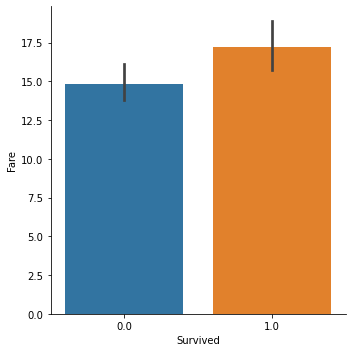

In [27]:
# Pclass 1 Survived =>
#sns.distplot(df.loc[df['Pclass']!=1,'Fare'],color='k')
# f, ax = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
# ax[0].set_title('Fare Class 1')
# sns.distplot(df.loc[df['Pclass']==1,'Fare'],color='r',ax=ax[0])
# ax[1].set_title('Fare Class 2')
# sns.distplot(df.loc[df['Pclass']==2,'Fare'],color='k',ax=ax[1])
# ax[2].set_title('Fare Class 3')
# sns.distplot(df.loc[df['Pclass']==3,'Fare'],color='g',ax=ax[2])

sns.catplot(data=df.loc[df['Pclass']!=1,:],y='Fare',x='Survived',kind='bar')

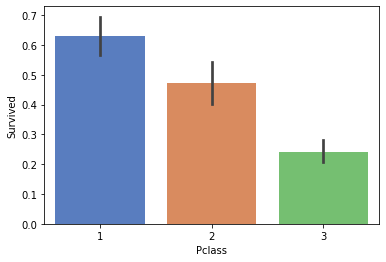

In [30]:
sns.barplot(data=df, y='Survived',x='Pclass', palette="muted")

In [31]:
for col in df.dtypes[df.dtypes == 'object'].index:
    df[col] = df[col].map(df.groupby(col).Survived.mean().fillna(df.Survived.mean()))
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,name_treatment,name_family,family_size,Embarked_Q,Embarked_S,Cabin_qtd,Cabin_first_letter,fare_per_person,fare_per_class,family_x_class
0,1,0.0,3,0.0,0,22.0,1,0,0.0,7.2500,...,0.156673,0.0,2,0,1,1,0.577465,3.62500,2.416667,6
1,2,1.0,1,1.0,1,38.0,1,0,1.0,71.2833,...,0.800000,1.0,2,0,0,1,0.573770,35.64165,71.283300,2


In [41]:
df.drop(['Name','Ticket','Cabin','Embarked'],axis=1,inplace=True)

## Reescaling features

In [33]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

In [34]:
to_scale_columns = [col for col in df.columns if col not in ['PassengerId','Survived']]
df[to_scale_columns] = scaler.fit_transform(df[to_scale_columns])
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,name_treatment,name_family,family_size,Embarked_Q,Embarked_S,Cabin_qtd,Cabin_first_letter,fare_per_person,fare_per_class,family_x_class
0,1,0.0,0.841916,-0.955908,-0.743497,-0.547050,0.481288,-0.445,-0.987404,-0.503173,...,-0.814750,-0.981604,0.073352,-0.32204,0.655011,-0.17643,1.510066,-0.472285,-0.446508,0.341813
1,2,1.0,-1.546098,1.533334,1.344995,0.563552,0.481288,-0.445,1.470706,0.734810,...,1.459795,1.480428,0.073352,-0.32204,-1.526692,-0.17643,1.477442,0.423318,0.844527,-0.507206


In [42]:
df.drop(['Cabin_number'],axis=1,inplace=True)

KeyError: "['Cabin_number'] not found in axis"

## Age Predict and feature Engineering

In [45]:
to_age_predict_cols = [col for col in df.columns if col not in ['PassengerId','Survived','Age']]

In [46]:
age_train_x

,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_first_letter,...,name_treatment,name_family,family_size,Embarked_Q,Embarked_S,Cabin_qtd,Cabin_first_letter,fare_per_person,fare_per_class,family_x_class
0,0.841916,-0.955908,-0.743497,0.481288,-0.445000,-0.987404,-0.503173,NaN,-0.572292,-1.826913,...,-0.814750,-0.981604,0.073352,-0.322040,0.655011,-0.17643,1.510066,-0.472285,-0.446508,0.341813
1,-1.546098,1.533334,1.344995,0.481288,-0.445000,1.470706,0.734810,1.003997,1.933095,1.486059,...,1.459795,1.480428,0.073352,-0.322040,-1.526692,-0.17643,1.477442,0.423318,0.844527,-0.507206
2,0.841916,1.533334,1.344995,-0.479087,-0.445000,1.470706,-0.490123,NaN,-0.572292,-0.368353,...,1.098465,1.480428,-0.558346,-0.322040,0.655011,-0.17643,1.510066,-0.352001,-0.442290,-0.294951
3,-1.546098,1.533334,1.344995,0.481288,-0.445000,0.241651,0.383265,-0.316276,-0.572292,1.394124,...,1.459795,0.249412,0.073352,-0.322040,0.655011,-0.17643,1.477442,0.168997,0.503646,-0.507206
4,0.841916,-0.955908,-0.743497,-0.479087,-0.445000,-0.987404,-0.487707,0.123815,-0.572292,-0.849778,...,-0.814750,0.249412,-0.558346,-0.322040,0.655011,-0.17643,0.510611,-0.348504,-0.441509,-0.294951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,0.841916,-0.000442,1.344995,0.481288,0.710763,-0.043887,-0.377023,NaN,-0.572292,-0.368353,...,1.098465,-0.036582,0.705051,-0.322040,0.655011,-0.17643,-0.800720,-0.445244,-0.405734,0.978576
411,-1.546098,-0.000442,1.344995,0.481288,-0.445000,0.241651,1.096668,-0.316276,0.018564,1.394124,...,1.459795,0.249412,0.073352,3.105202,-1.526692,-0.17643,1.477442,0.685100,1.195406,-0.507206
412,0.841916,-0.000442,1.344995,-0.479087,-0.445000,-0.043887,-0.493023,NaN,-0.572292,-0.849778,...,1.098465,-0.036582,-0.558346,-0.322040,0.655011,-0.17643,-0.800720,-0.356197,-0.443228,-0.294951
414,-1.546098,-0.000442,1.344995,-0.479087,-0.445000,0.241651,1.462070,-0.623007,1.933095,1.486059,...,1.459795,-0.036582,-0.558346,-0.322040,-1.526692,-0.17643,1.477442,2.472578,1.549723,-0.719460


In [49]:
from sklearn.svm import SVR
age_model = SVR()
age_train_x = df.loc[df['Age'].isna() == False, to_age_predict_cols]
age_train_y = df.loc[df['Age'].isna() == False, "Age"]
##################
age_model = age_model.fit(age_train_x,age_train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [50]:
age_test_x = df.loc[df['Age'].isna(), to_age_predict_cols]
df.loc[df['Age'].isna(), "Age"] = age_model.predict(age_test_x)
df.head(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Ticket_first_letter,Ticket_first_letter_freq,...,name_treatment,name_family,family_size,Embarked_Q,Embarked_S,Cabin_qtd,Cabin_first_letter,fare_per_person,fare_per_class,family_x_class
0,1,0.0,0.841916,-0.743497,-0.547050,0.481288,-0.445,-0.503173,-1.826913,-1.472774,...,-0.814750,-0.981604,0.073352,-0.32204,0.655011,-0.17643,1.510066,-0.472285,-0.446508,0.341813
1,2,1.0,-1.546098,1.344995,0.563552,0.481288,-0.445,0.734810,1.486059,-1.084834,...,1.459795,1.480428,0.073352,-0.32204,-1.526692,-0.17643,1.477442,0.423318,0.844527,-0.507206


In [ ]:
print(df['Age'].isnull().sum())
df['Pclass_x_Age'] = df['Pclass']*df['Age']
df.head(2)

In [90]:
from sklearn.decomposition import PCA

pcax = PCA(n_components=3)
graph = pcax.fit_transform(df.drop('Survived',axis=1))

In [91]:
pd.DataFrame(graph).corr()

,0,1,2
0,1.000000e+00,-3.489646e-17,-3.363765e-17
1,-3.489646e-17,1.000000e+00,4.181949e-17
2,-3.363765e-17,4.181949e-17,1.000000e+00


In [88]:
pca_variances = pcax.explained_variance_ratio_
pca_variances[:5].cumsum()

array([0.9998545 , 0.99989161])

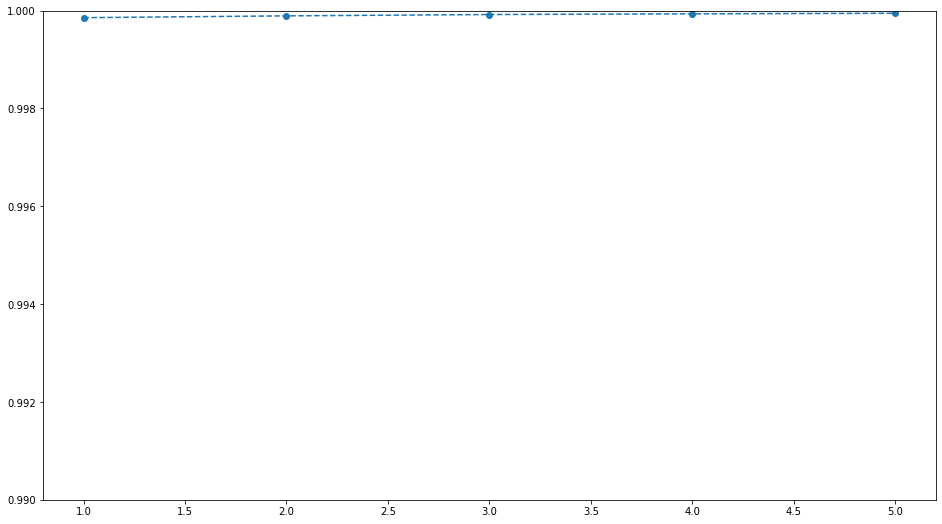

In [66]:
plt.figure(figsize=(16,9))
pca_variances = pca.explained_variance_ratio_
plt.ylim(0.99,1)
plt.plot(range(1,6),pca_variances[:5].cumsum(),marker="o",linestyle="--")

In [51]:
df.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Ticket_first_letter,Ticket_first_letter_freq,...,name_treatment,name_family,family_size,Embarked_Q,Embarked_S,Cabin_qtd,Cabin_first_letter,fare_per_person,fare_per_class,family_x_class
PassengerId,1.000000,-0.005007,-0.038354,-0.013406,0.021673,-0.055224,0.008942,0.031027,0.039109,-0.006967,...,-0.005988,0.049760,-0.031437,0.011585,-0.049836,0.032723,0.165896,0.035072,0.032488,-0.044603
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.074570,-0.035322,0.081629,0.257307,0.360804,-0.101610,...,0.579430,0.908700,0.016639,0.003650,-0.149683,0.082933,0.212662,0.221600,0.267627,-0.116214
Pclass,-0.038354,-0.338481,1.000000,-0.124617,-0.409163,0.060832,0.018322,-0.558742,-0.755152,0.358657,...,-0.124863,-0.297914,0.050027,0.230491,0.091320,-0.206572,-0.373674,-0.504337,-0.602772,0.370104
Sex,-0.013406,0.543351,-0.124617,1.000000,-0.072752,0.109609,0.213125,0.185746,0.122687,-0.027684,...,0.934497,0.364187,0.188583,0.088651,-0.115193,0.047797,0.096755,0.131368,0.175423,0.114274
Age,0.021673,-0.074570,-0.409163,-0.072752,1.000000,-0.213343,-0.134487,0.179459,0.276384,-0.132561,...,-0.147860,0.002592,-0.213835,-0.014064,-0.052886,0.054364,0.156097,0.198222,0.218388,-0.320783
SibSp,-0.055224,-0.035322,0.060832,0.109609,-0.213343,1.000000,0.373587,0.160389,-0.038949,-0.042335,...,0.212133,-0.037815,0.861952,-0.048678,0.073709,0.087334,0.001700,-0.089666,0.074880,0.818737
Parch,0.008942,0.081629,0.018322,0.213125,-0.134487,0.373587,1.000000,0.221668,-0.002317,-0.061780,...,0.297162,0.076361,0.792296,-0.100943,0.071881,0.209878,0.067892,-0.065370,0.150722,0.697086
Fare,0.031027,0.257307,-0.558742,0.185746,0.179459,0.160389,0.221668,1.000000,0.449118,-0.232699,...,0.201107,0.228750,0.226654,-0.129921,-0.170124,0.513942,0.279315,0.832045,0.989931,-0.030519
Ticket_first_letter,0.039109,0.360804,-0.755152,0.122687,0.276384,-0.038949,-0.002317,0.449118,1.000000,-0.294121,...,0.131127,0.324004,-0.026885,-0.192187,-0.243107,0.180746,0.285361,0.418037,0.475311,-0.265067
Ticket_first_letter_freq,-0.006967,-0.101610,0.358657,-0.027684,-0.132561,-0.042335,-0.061780,-0.232699,-0.294121,1.000000,...,-0.032470,-0.078323,-0.061613,0.295271,-0.035572,-0.083930,-0.138511,-0.211794,-0.225556,0.045902


# Clustering

In [284]:
from sklearn.cluster import KMeans
def reducing_kmeans(num_cluster,dados):
    modelo = KMeans(n_clusters=num_cluster)
    modelo.fit(dados)
    return [num_cluster,modelo.inertia_]

In [285]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Ticket_first_letter', 'Ticket_first_letter_freq',
       'has_unique_ticket', 'has_cabin', 'has_age', 'name_treatment',
       'name_family', 'family_size', 'Embarked_Q', 'Embarked_S', 'Cabin_qtd',
       'Cabin_first_letter', 'fare_per_person', 'fare_per_class',
       'family_x_class', 'Pclass_x_Age'],
      dtype='object')

In [286]:
cluster_results = [reducing_kmeans(num_cluster,df.drop(['Survived','PassengerId'],axis=1)) for num_cluster in range(1,31)]
cluster_results = pd.DataFrame(cluster_results, columns=['Clusters','Inertia'])
cluster_results.head(2)

,Clusters,Inertia
0,1,28417.074208
1,2,23347.700964


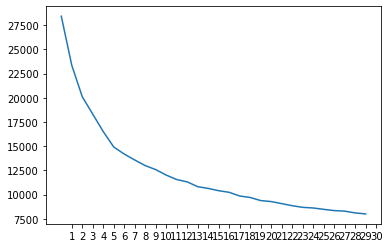

In [287]:
cluster_results.Inertia.plot(xticks=cluster_results.Clusters)

In [288]:
modelo = KMeans(n_clusters=7)
modelo.fit(df.drop(['Survived','PassengerId'],axis=1))
df['clusters'] = modelo.labels_
df.head(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Ticket_first_letter,Ticket_first_letter_freq,...,family_size,Embarked_Q,Embarked_S,Cabin_qtd,Cabin_first_letter,fare_per_person,fare_per_class,family_x_class,Pclass_x_Age,clusters
0,1,0.0,0.841916,-0.743497,-0.547050,0.481288,-0.445,-0.503173,-1.826913,-1.472774,...,0.073352,-0.32204,0.655011,-0.17643,1.510066,-0.472285,-0.446508,0.341813,-0.460571,1
1,2,1.0,-1.546098,1.344995,0.563552,0.481288,-0.445,0.734810,1.486059,-1.084834,...,0.073352,-0.32204,-1.526692,-0.17643,1.477442,0.423318,0.844527,-0.507206,-0.871306,3


In [289]:
df = pd.concat([df.drop(['clusters'],axis=1),pd.get_dummies(df['clusters'],prefix="cluster",drop_first=True)],axis=1)
print(df.shape)
df.head(2)

(1309, 30)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Ticket_first_letter,Ticket_first_letter_freq,...,fare_per_person,fare_per_class,family_x_class,Pclass_x_Age,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
0,1,0.0,0.841916,-0.743497,-0.547050,0.481288,-0.445,-0.503173,-1.826913,-1.472774,...,-0.472285,-0.446508,0.341813,-0.460571,1,0,0,0,0,0
1,2,1.0,-1.546098,1.344995,0.563552,0.481288,-0.445,0.734810,1.486059,-1.084834,...,0.423318,0.844527,-0.507206,-0.871306,0,0,1,0,0,0


# Train - Test Split
---
just to divide our data again, and for we do our keras validation too in model developing

In [290]:
df.to_pickle('Bases/base_modelada.pkl')



In [291]:
df.drop(['name_family'],axis=1,inplace=True)

In [292]:
train_set = df[df['PassengerId'].isin(to_split_later_train)]
train_set['Survived'] = train_set['Survived'].astype(int)
train_set = train_set.set_index('PassengerId')
train_set.tail(2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Ticket_first_letter,Ticket_first_letter_freq,has_unique_ticket,...,fare_per_person,fare_per_class,family_x_class,Pclass_x_Age,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
PassengerId,,,,,,,,,,,,,,,,,,,,,
890,1,-1.546098,-0.743497,-0.269400,-0.479087,-0.445,-0.063338,1.394124,-0.308954,0.914278,...,0.265504,0.070593,-0.719460,0.416519,0,0,0,0,0,0
891,0,0.841916,-0.743497,0.147076,-0.479087,-0.445,-0.493507,-0.849778,1.208169,0.914278,...,-0.356896,-0.443384,-0.294951,0.123826,0,0,0,1,0,0


In [202]:
test_set = df[df['PassengerId'].isin(to_split_later_test)]
test_set = test_set.set_index('PassengerId')
test_set.head(2)

NameError: name 't' is not defined

# Testes

In [48]:
import statsmodels.api as sm

In [53]:
x_train = train_set.drop('Survived',axis=1)
y_train = train_set['Survived'].values

In [54]:
model = sm.Logit(y_train,x_train)
result = model.fit(method='newton')
result.summary()

Optimization terminated successfully.
         Current function value: 0.378714
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      865
Method:                           MLE   Df Model:                           25
Date:                Thu, 03 Sep 2020   Pseudo R-squ.:                  0.4313
Time:                        09:49:22   Log-Likelihood:                -337.43
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 2.774e-92
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pclass                       0.0606      0.331      0.183      0.855      -0.587       0.708
Sex                         -0.5510      0.314     -1.757      0.079      -1.166       0.064
Age                         -0.4884      0.143     -3.422      0.001      -0.768      -0.209
SibSp                        0.4853   7.13e+06   6.81e-08      1.000    -1.4e+07     1.4e+07
Parch                        0.4857   5.92e+06    8.2e-08      1.000   -1.16e+07    1.16e+07
Fare                         1.4167      1.208      1.173      0.241      -0.951       3.784
Ticket_first_letter          0.5561      0.165      3.371      0.001       0.233       0.879
Ticket_first_letter_freq    -0.0539      0.119     -0.452      0.651      -0.288       0.180
has_unique_ticket            0.2218      0.157      1.412      0.158      -0.086       0.530
has_cabin                    0.3243      0.177      1.833      0.067      -0.023       0.671
has_age                      0.1211      0.115      1.053      0.292      -0.104       0.347
name_treatment               2.0647      0.385      5.368      0.000       1.311       2.819
family_size                  0.5846   1.08e+07   5.39e-08      1.000   -2.12e+07    2.12e+07
Embarked_Q                  -0.8089      0.428     -1.891      0.059      -1.647       0.030
Embarked_S                  -0.0188      0.130     -0.145      0.885      -0.274       0.236
Cabin_qtd                   -0.0934      0.169     -0.554      0.580      -0.424       0.237
Cabin_first_letter           0.0548      0.137      0.401      0.688      -0.213       0.323
fare_per_person              0.6200      0.397      1.563      0.118      -0.157       1.397
fare_per_class              -2.1658      1.139     -1.901      0.057      -4.399       0.067
family_x_class              -1.5849      0.838     -1.892      0.058      -3.227       0.057
Pclass_x_Age                -0.1035      0.132     -0.786      0.432      -0.362       0.155
cluster_1                   -0.9484      0.560     -1.694      0.090      -2.045       0.149
cluster_2                    2.6230      1.387      1.891      0.059      -0.095       5.342
cluster_3                   -0.2351      0.610     -0.385      0.700      -1.431       0.961
cluster_4                   -3.2206      0.971     -3.316      0.001      -5.124      -1.317
cluster_5                   -0.9367      0.332     -2.821      0.005      -1.587      -0.286
cluster_6                   -0.9482      0.363     -2.611      0.009      -1.660      -0.237
============================================================================================
"""

In [61]:
x_test = test_set.drop('Survived',axis=1)
y_test = result.predict(x_test)
logistic_output = pd.DataFrame((y_test >= 0.5).astype(int),columns=['Survived']).reset_index()
logistic_output.to_csv("Submissions/" + str(datetime.today().date()) + " Statsmodels LogisticRegression.csv",index=False)

# Modelling - Keras

In [48]:
from tensorflow import keras
import tensorflow as tf

In [49]:
train_set.shape

(891, 28)

In [50]:
modelo = keras.Sequential([
    keras.layers.Dense(128,activation=tf.nn.relu),
    keras.layers.Dropout(0.2,seed=1),
    keras.layers.Dense(64,activation=tf.nn.relu),
    keras.layers.Dense(4,activation=tf.nn.relu),
    keras.layers.Dense(1,activation=tf.nn.sigmoid)
])

modelo.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])


In [51]:
historico = modelo.fit(train_set.drop('Survived',axis=1).values,train_set['Survived'].values,epochs=150,validation_split=0.2,verbose=False,shuffle=True)

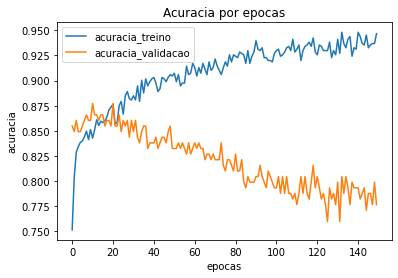

In [52]:
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])
plt.title("Acuracia por epocas")
plt.xlabel('epocas')
plt.ylabel('acuracia')
plt.legend(['acuracia_treino','acuracia_validacao'])

In [53]:
test_set['Survived'] = np.round(modelo.predict(test_set.drop('Survived',axis=1).values))
test_set['Survived'] = test_set['Survived'].astype(int)
print(test_set.shape)
test_set.head(2)

(418, 28)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Ticket_first_letter,Ticket_first_letter_freq,has_unique_ticket,...,fare_per_person,fare_per_class,family_x_class,Pclass_x_Age,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,0,0.841916,-0.743497,0.320607,-0.479087,-0.445,-0.491975,-0.849778,1.208169,0.914278,...,-0.354681,-0.442889,-0.294951,0.269925,0,0,1,0,0,0
893,0,0.841916,1.344995,1.188265,0.481288,-0.445,-0.508007,-0.849778,1.208169,0.914278,...,-0.475782,-0.448071,0.341813,1.000420,0,0,0,0,0,0


In [55]:
#test_set.reset_index().loc[:,['PassengerId','Survived']].to_csv("Submissions/" + str(datetime.today().date()) + " Keras .csv",index=False)

# Modelling XgBoost

In [56]:
from xgboost import XGBClassifier

x_train = train_set.drop('Survived',axis=1).values
y_train = train_set['Survived'].values


param_grid = {
    'n_estimators' :[10,50,100,1000,8000],
    'learning_rate' :[1,0.1,0.5,0.05,0.005,0.0005],
    'early_stopping_rounds' :[10,20,50,100]
}

def best_param(model,param_grid,x_train,y_train):
    try:
        clf = RandomizedSearchCV(model, param_grid, n_jobs=-1, cv=5)
        return clf.best_estimator_
    except:
        return model

xgb_model = best_param(XGBClassifier(random_state=1),param_grid,x_train,y_train)     
 
from sklearn.model_selection import cross_val_score


xgb_model.fit(x_train, y_train)
scores = cross_val_score(xgb_model, x_train, y_train, cv=10, scoring = "accuracy")
print(scores)
print(scores.mean())
xgb_model

[0.74444444 0.81111111 0.7752809  0.78651685 0.92134831 0.86516854
 0.83146067 0.79775281 0.85393258 0.84090909]
0.8227925320621952


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

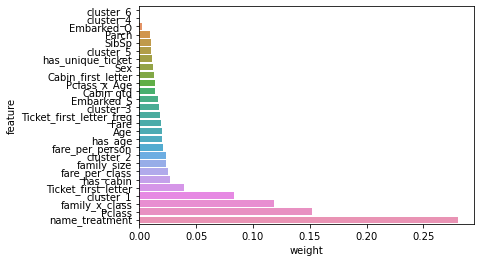

In [57]:
feature_importance = pd.DataFrame({"feature":train_set.drop("Survived",axis=1).columns,"weight":xgb_model.feature_importances_}).sort_values(by='weight')
sns.barplot(data=feature_importance,x='weight',y='feature')

# Outros Modelos

In [60]:
clf_bible = {}

x_train = train_set.drop('Survived',axis=1).values
y_train = train_set['Survived'].values


def best_param(model,param_grid,x_train,y_train):
    try:
        clf = RandomizedSearchCV(model, param_grid, n_jobs=-1, cv=5)
        return clf.best_estimator_
    except:
        return model


# SVC


from sklearn import svm

param_grid = {
    "random_state": [1],
    "degree":[1,2,3,4],
    "kernel" : ['poly','rbf', 'sigmoid'],
    "gamma": ['auto','scale']
}


clf_bible["SVC"] = best_param(svm.SVC(random_state=1),param_grid,x_train,y_train)    

param_grid = {
    "random_state": [1],
    "nu": [0.25,0.5,0.75],
    "degree":[1,2,3,4],
    "kernel" : ['poly','rbf', 'sigmoid'],
    "gamma": ['auto','scale']
}
    
    
clf_bible["nuSVC"] = best_param(svm.NuSVC(),param_grid,x_train,y_train)    


from xgboost import XGBClassifier
param_grid = {
    'n_estimators' :[10,30,100,1000,8000],
    'learning_rate' :[1,0.1,0.5,0.05,0.005,0.0005],
    'early_stopping_rounds' :[10,20,50,100]
}
clf_bible["Xgboost"] = best_param(XGBClassifier(random_state=1),param_grid,x_train,y_train)     
 
    
# Neural Network
from sklearn.neural_network import MLPClassifier
param_grid = {
       "activation":['identity', 'logistic', 'tanh', 'relu']
}
clf_bible["MLPClassifier"] = best_param(MLPClassifier(),param_grid,x_train,y_train)


from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression


param_grid = {
    "loss":['hinge', 'log', 'modified_huber','squared_hinge', 'perceptron'],
    "random_state":[1],
}

clf_bible["SGDClassifier"] = best_param(SGDClassifier(),param_grid,x_train,y_train)

clf_bible["LogisticRegression"] = LogisticRegression()


from sklearn.neighbors import RadiusNeighborsClassifier

param_grid = {
    "weights" :["uniform",'distance'],
    "radius" :[2,3,4,5]
}

#clf_bible["RadiusNeighborsClassifier"] = best_param(RadiusNeighborsClassifier(),param_grid,x_train,y_train)

from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    "weights" :["uniform",'distance'],
    "n_neighbors" :[2,3,4,5,6,10,15,30]
}

clf_bible["KNeighborsClassifier"] = best_param(KNeighborsClassifier(),param_grid,x_train,y_train)



from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(1.0)
clf_bible["GaussianProcessClassifier"] = GaussianProcessClassifier(kernel=kernel,random_state=1)

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
# clf_bible["GaussianNB"] = GaussianNB()
# clf_bible["MultinomialNB"] = MultinomialNB()
# clf_bible["ComplementNB"] = ComplementNB()
# clf_bible["BernoulliNB"] = BernoulliNB()

from sklearn.ensemble import AdaBoostClassifier
clf_bible["AdaBoostClassifier"] = AdaBoostClassifier(random_state=1)


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Ensemble

param_grid = {
    "random_state":[1],
    "criterion" : ["gini", "entropy"],
    "n_estimators":[10,50,100,200,300],
    "min_samples_leaf" : [1, 5, 10, 25, 50, 70], 
    "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35]
}

clf_bible['RandomForestClassifier'] = best_param(RandomForestClassifier(),param_grid,x_train,y_train)
clf_bible['DecisionTreeClassifier'] = best_param(DecisionTreeClassifier(),param_grid,x_train,y_train)


clf_bible

{'SVC': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
     kernel='rbf', max_iter=-1, probability=False, random_state=1,
     shrinking=True, tol=0.001, verbose=False),
 'nuSVC': NuSVC(cache_size=200, class_weight=None, coef0=0.0,
       decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
       kernel='rbf', max_iter=-1, nu=0.5, probability=False, random_state=None,
       shrinking=True, tol=0.001, verbose=False),
 'Xgboost': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='bi

In [61]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings

warnings.filterwarnings("ignore")
def test_model(clf_name,model,x_train,y_train):
    model.fit(x_train, y_train)
    scores = cross_val_score(model, x_train, y_train, cv=10, scoring = "accuracy")
    return pd.DataFrame([[clf_name, round(model.score(x_train, y_train),2), round(scores.mean(),2), round(scores.std(),2)]])

all_models = pd.DataFrame()    
for clf in clf_bible:
    print(f"Modelo {clf}")
    all_models = all_models.append(test_model(clf,clf_bible[clf],x_train,y_train))
all_models = all_models.rename(columns={0:"Modelo",1:"Score Geral",2:"Média (10 scores)", 3: "Standard Deviation"})
all_models.sort_values(by=["Média (10 scores)","Standard Deviation","Score Geral"], ascending=[False,True,False], inplace=True)
all_models

Modelo SVC
Modelo nuSVC
Modelo Xgboost
Modelo MLPClassifier
Modelo SGDClassifier
Modelo LogisticRegression
Modelo KNeighborsClassifier
Modelo GaussianProcessClassifier
Modelo AdaBoostClassifier
Modelo RandomForestClassifier
Modelo DecisionTreeClassifier


,Modelo,Score Geral,Média (10 scores),Standard Deviation
0,GaussianProcessClassifier,0.86,0.84,0.02
0,RandomForestClassifier,0.99,0.83,0.03
0,SVC,0.85,0.83,0.03
0,nuSVC,0.84,0.83,0.03
0,LogisticRegression,0.84,0.83,0.03
0,MLPClassifier,0.90,0.83,0.04
0,AdaBoostClassifier,0.86,0.82,0.02
0,Xgboost,1.00,0.82,0.05
0,KNeighborsClassifier,0.87,0.81,0.04
0,SGDClassifier,0.80,0.78,0.07


In [62]:
x_test = test_set.drop('Survived',axis=1).values

In [73]:
all_models.iloc[6][0]

'AdaBoostClassifier'

In [74]:
def export_best_model(all_models,clf_bible,x_train,y_train):
    best_model = all_models.iloc[6][0]
    print(f"O melhor modelo é :{best_model}")
    model = clf_bible[best_model]
    model.fit(x_train, y_train)
    y_test = model.predict(x_test)
    output = pd.DataFrame({'PassengerId': test_set.index, 'Survived': y_test})
    output['Survived'] = output['Survived'].astype(int)
    actual_day = str(datetime.today().date())
    output.to_csv(f'Submissions/{actual_day} {best_model}.csv', index=False)
    
export_best_model(all_models,clf_bible,x_train,y_train)

O melhor modelo é :AdaBoostClassifier
